In [1]:
# %load defaults.ipy
import numpy as np
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 600
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append('../python')
from plot_info import showAndSave, savePlot, get_environment
import plot_info
plot_info.set_notebook_name("WassersteinDistances.ipynb")

import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import os
import h5py
import ot
import sys
import scipy
import scipy.stats

for p in sys.path:
    if 'matplotlib' in p.lower():
        sys.path.remove(p)
    if 'netcdf' in p.lower():
        sys.path.remove(p)

from mpl_toolkits.mplot3d import Axes3D
def showAndSave(name, savetikz=True):
    name = name.replace('.', '').replace('=','').replace(' ', '')
    
    
    print ("Saving %s" % name)
    if savetikz:
        matplotlib2tikz.save('img_tikz/' + name + '.tikz',
           figureheight = '\\figureheight',
           figurewidth = '\\figurewidth')
    
    plt.savefig('img/' + name + '.png', bbox_inches='tight')
    plt.show()
    plt.close('all')

def load(f, sample):
    if '.nc' in f:
        with netCDF4.Dataset(f) as d:
            return d.variables['sample_%d_rho' % sample][:,:,0]
    else:
        f = os.path.join(f, 'kh_%d/kh_1.h5' % sample)
        with h5py.File(f) as d:
            return d['rho'][:,:,0]

/usr/lib64/python3.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Histogram plotting

In [2]:
def plot_histograms2(N, M, name, minValue, maxValue, x, y, xp, yp, valuesx, valuesy):
    
    
    
   
    
    plt.hist2d(valuesx, valuesy, bins=20, normed=True, range=[[minValue, maxValue], [minValue, maxValue]])
    plt.colorbar()
    plt.xlabel('Value of $\\rho(%.2f,%.2f)$' % (x,y))
    plt.ylabel('Value of $\\rho(%.2f,%.2f)$' % (xp,yp))
    plt.title('Histogram at resolution %d, for %s,\nbetween $(%.2f, %.2f)$ and $(%.2f, %.2f)$' %  (N, name, x,y,xp,yp))
    
    showAndSave('hist2pt_%s_%d_%.1f_%.1f_%.1f_%.1f' %(name, N, x, y, xp, yp))
    
    H, xedges, yedges = histogram2d(valuesx, valuesy, bins=20, normed=True,range=[[minValue, maxValue], [minValue, maxValue]])
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    Xvalues, Yvalues = meshgrid(xedges[:-1], yedges[:-1])
    surf = ax.plot_surface(Xvalues, Yvalues, H)
    plt.xlabel('Value of $\\rho(%.2f,%.2f)$' % (x,y))
    plt.ylabel('Value of $\\rho(%.2f,%.2f)$' % (xp,yp))
    plt.title('Histogram at resolution %d, for %s,\nbetween $(%.2f, %.2f)$ and $(%.2f, %.2f)$' % (N, name, x,y,xp,yp))
    
    showAndSave('hist2pt_surface_%s_%d_%.1f_%.1f_%.1f_%.1f' %(name, N, x, y, xp, yp), savetikz=False)

In [3]:
def plotHistograms(name, resolutions, basename, samples):
    data = {}
    for r in resolutions:
        filename = basename % r
        datar = np.zeros((r,r, samples))
        for k in range(samples):
            datar[:,:,k] = load(filename, k)
        data[r] = datar
    points = [0.2, 0.4, 0.7, 0.8]
    for x in points:
        for y in points:
            for xp in points:
                for yp in points:
                    # First we find minimum and maximum over all resolutions and all samples
                    # we need this to equalize the histograms properly.
                    min_value = 1e8
                    max_value = -1e8
                    for r in resolutions:
                        
                        i = int(x*r)
                        j = int(y*r)
                        ip = int(xp*r)
                        jp = int(yp*r)

                        
                        for k in range(samples):
                            datasample = data[r][:,:,k]
                            min_value = min(np.amin([datasample[i,j], datasample[ip,jp]]), min_value)
                            max_value = max(np.amax([datasample[i,j], datasample[ip,jp]]), max_value)

                    
                    for r in resolutions:
                        valuesx = []
                        valuesy = []
                        
                        i = int(x*r)
                        j = int(y*r)
                        ip = int(xp*r)
                        jp = int(yp*r)
                        
                        for k in range(samples):
                            datasample = data[r][:,:,k]
                            valuesx.append(datasample[i, j])
                            valuesy.append(datasample[ip, jp])

                        plot_histograms2(r, samples, name, min_value, max_value, x,y, xp, yp, valuesx, valuesy)

            

# Computing Wasserstein distances

In [64]:
def wasserstein_point2_fast(data1, data2, i, j, ip, jp, a, b, xs, xt):
    """
    Computes the Wasserstein distance for a single point in the spatain domain
    """
    

    xs[:,0] = data1[i,j,:]
    xs[:,1] = data1[ip, jp, :]

    xt[:,0] = data2[i,j, :]
    xt[:,1] = data2[ip, jp, :]


    M = ot.dist(xs, xt, metric='euclidean')
    G0 = ot.emd(a,b,M)

    return np.sum(G0*M)

def wasserstein1pt_fast(data1, data2):
    """
    Approximate the L^1(W_1) distance (||W_1(nu1, nu2)||_{L^1})
    """
    N = data1.shape[0]
    distance = 0
    
    for i in range(N):
        for j in range(N):
            distance += scipy.stats.wasserstein_distance(data1[i,j,:], data2[i,j,:])


    
    return distance / N**2



def wasserstein2pt_fast(data1, data2):
    """
    Approximate the L^1(W_1) distance (||W_1(nu1, nu2)||_{L^1})
    """
    N = data1.shape[0]
    a = np.ones(N)/N
    b = np.ones(N)/N
    xs = np.zeros((N,2))
    xt = np.zeros((N,2))
    distance = 0
    

    points = 0.1*np.array(range(0,10))
    for (n,x) in enumerate(points):
        for y in points:

            for xp in points:
                for yp in points:
                    i = int(x*N)
                    j = int(y*N)
                    ip = int(xp*N)
                    jp = int(yp*N)
                    distance += wasserstein_point2_fast(data1, data2, i,j, ip, jp, a, b, xs, xt)


    
    return distance / len(points)**4



def plotWassersteinConvergence(name, basename, resolutions):
    wasserstein2pterrors = []
    for r in resolutions[1:]:
        filename = basename % r
        filename_coarse = basename % int(r/2)
        data1 = np.zeros((r,r,r))
        data2 = np.zeros((r,r,r))
        for k in range(r):
            d1 = load(filename, k)
            d2 = np.repeat(np.repeat(load(filename_coarse, k), 2,0), 2,1)
            data1[:,:,k] = d1
            data2[:,:,k] = d2

        wasserstein2pterrors.append(wasserstein2pt_fast(data1, data2))
        print("wasserstein2pterrors=%s" % wasserstein2pterrors)
    

    plt.loglog(resolutions[1:], wasserstein2pterrors, '-o', basex=2, basey=2)
    plt.xlabel("Resolution")
    plt.xticks(resolutions[1:], ['${r} \\times {r}$'.format(r=r) for r in resolutions[1:]])
    plt.ylabel('$||W_1(\\nu^{2, \\Delta x}, \\nu^{2,\\Delta x/2})||_{L^1(D\\times D)}$')
    plt.title("Wasserstein convergence for %s\nfor second correlation marginal"%name)
    showAndSave('%s_wasserstein_convergence_2pt' % name)
    
    
    
    wasserstein1pterrors = []
    for r in resolutions[1:]:
        filename = basename % r
        filename_coarse = basename % int(r/2)
        data1 = np.zeros((r,r,r))
        data2 = np.zeros((r,r,r))
        for k in range(r):
            d1 = load(filename, k)
            d2 = np.repeat(np.repeat(load(filename_coarse, k), 2,0), 2,1)
            data1[:,:,k] = d1
            data2[:,:,k] = d2

        wasserstein1pterrors.append(wasserstein1pt_fast(data1, data2))
        print("wasserstein1pterrors=%s" % wasserstein1pterrors)
    

    plt.loglog(resolutions[1:], wasserstein1pterrors, '-o', basex=2, basey=2)
    plt.xlabel("Resolution")
    plt.xticks(resolutions[1:], ['${r} \\times {r}$'.format(r=r) for r in resolutions[1:]])
    plt.ylabel('$||W_1(\\nu^{1, \\Delta x}, \\nu^{1, \\Delta x/2})||_{L^1(D)}$')
    plt.title("Wasserstein convergence for %s\nfor first correlation marginal"%name)
    showAndSave('%s_wasserstein_convergence_1pt' % name)
    
    


def plotWassersteinConvergenceVaryingMethods(name, filenames, resolutions):
    # two point
    wasserstein2pterrors = []
    types = [t for t in filenames.keys()]
    for filename_a, filename_b in zip(filenames[types[0]], filenames[types[1]]):
        
        data1 = np.zeros((r,r,r))
        data2 = np.zeros((r,r,r))
        for k in range(r):
            d1 = load(filename, k)
            d2 = load(filename_coarse, k)
            if d1.shape[0] < d2.shape[0]:
                d2,d1 = d1, d2
            d2 = np.repeat(np.repeat(d2, 2,0), 2, 1)
            
            data1[:,:,k] = d1
            data2[:,:,k] = d2

        wasserstein2pterrors.append(wasserstein2pt_fast(data1, data2))
        print("wasserstein2pterrors=%s" % wasserstein2pterrors)
    

    plt.loglog(resolutions, wasserstein2pterrors, '-o', basex=2, basey=2)
    plt.xlabel("Resolution")
    plt.xticks(resolutions, ['${r} \\times {r}$'.format(r=r) for r in resolutions])
    plt.ylabel('$||W_1(\\nu^{2, \\Delta x}, \\nu^{2,\\Delta x/2})||_{L^1(D\\times D)}$')
    plt.title("Wasserstein convergence for %s\nfor second correlation marginal"%name)
    showAndSave('%s_scheme_wasserstein_convergence_2pt' % name)
    
    # one point
    wasserstein1pterrors = []
    types = [t for t in filenames.keys()]
    for filename_a, filename_b in zip(filenames[types[0]], filenames[types[1]]):
        
        data1 = np.zeros((r,r,r))
        data2 = np.zeros((r,r,r))
        for k in range(r):
            d1 = load(filename, k)
            d2 = load(filename_coarse, k)
            if d1.shape[0] < d2.shape[0]:
                d2,d1 = d1, d2
            d2 = np.repeat(np.repeat(d2, 2,0), 2, 1)
            
            data1[:,:,k] = d1
            data2[:,:,k] = d2

        wasserstein1pterrors.append(wasserstein1pt_fast(data1, data2))
        print("wasserstein1pterrors=%s" % wasserstein1pterrors)
    

    plt.loglog(resolutions, wasserstein1pterrors, '-o', basex=2, basey=2)
    plt.xlabel("Resolution")
    plt.xticks(resolutions, ['${r} \\times {r}$'.format(r=r) for r in resolutions])
    plt.ylabel('$||W_1(\\nu^{1, \\Delta x}_{\\mathrm{%s}}, \\nu^{1,\\Delta x/2}_{\\mathrm{%s}})||_{L^1(D)}$' %(types[0], types[1]))
    plt.title("Wasserstein convergence for %s\nfor first correlation marginal"%name)
    showAndSave('%s_scheme_wasserstein_convergence_1pt' % name)

# Kelvin-Helmholtz

wasserstein2pterrors=[0.07207454003689508]
wasserstein2pterrors=[0.07207454003689508, 0.0432692588838205]
Saving Kelvin-Helmholtz_wasserstein_convergence_2pt
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


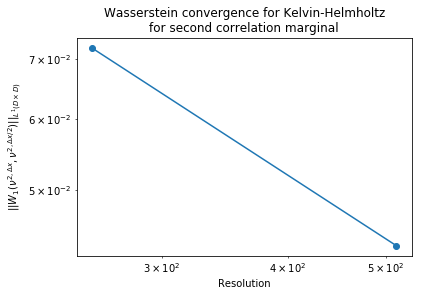

In [65]:
resolutions = [64, 128,256,512, 1024]
basename = 'kh_conv/n%d/kh_1.nc'
kh_basename_path = get_environment("STATISTICAL_RESOLUTIONS", 
                [basename % r for r in resolutions])

plot_info.console_log("Using kh_basename_path={}".format(kh_basename_path))



name = 'Kelvin-Helmholtz'
samples = 1024

plotWassersteinConvergence(name, os.path.join(kh_basename_path, basename), resolutions)
plotHistograms(name, resolutions, os.path.join(kh_basename_path, basename), samples)


# Richtmeyer-Meshkov

In [ ]:
resolutions = [64, 128,256,512, 1024]
basename = 'rm_conv/n%d/rm_1.nc'
name = 'Richtmeyer-Meshkov'
samples = 1024

rm_basename_path = get_environment("STATISTICAL_RESOLUTIONS", 
                [basename % r for r in resolutions])

plot_info.console_log("Using rm_basename_path={}".format(rm_basename_path))

plotWassersteinConvergence(name, os.path.join(rm_basename_path, basename), resolutions)
plotHistograms(name, resolutions, os.path.join(rm_basename_path, basename), samples)

# Brownian motion

In [ ]:
resolutions = [64, 128,256,512, 1024]
basename = 'brownian_conv/n%d/euler_brownian_1.nc'
name = 'Brownian motion'
samples = 1024

bm_basename_path = get_environment("STATISTICAL_RESOLUTIONS", 
                [basename % r for r in resolutions])

plot_info.console_log("Using bm_basename_path={}".format(bm_basename_path))

plotWassersteinConvergence(name, os.path.join(bm_basename_path, basename), resolutions)
plotHistograms(name, resolutions, os.path.join(bm_basename_path, basename), samples)

# Fractional Brownian motion H=0.1

In [ ]:
resolutions = [64, 128,256,512, 1024]
basename = 'fract01_conv/n%d/euler_brownian_1.nc'
name = 'Fractional Brownian motion H=0.1'
samples = 1024

fbm_basename_path = get_environment("STATISTICAL_RESOLUTIONS", 
                [basename % r for r in resolutions])

plot_info.console_log("Using fbm_basename_path={}".format(fbm_basename_path))

plotWassersteinConvergence(name, os.path.join(fbm_basename_path, basename), resolutions)
plotHistograms(name, resolutions, os.path.join(fbm_basename_path, basename), samples)

# Kelvin-Helmholtz convergence wrt to different numerical schemes


In this experiment, we have done two different numerical methods (weno and mc). We run several diferent mesh resolutions

$$\mathrm{Error}(\Delta)=\|W_1(\mu^{\Delta}_{\mathrm{weno}}, \mu^{\Delta}_{\mathrm{mc}})\|_{L^1}$$

We plot the error as a function of the mesh width $\Delta$. If the statisitical solution is invariant to the different numerical methods, we should get something that converges to zero.

In [ ]:
name='Kelvin-Helmholtz varying numerical scheme'
resolutions = [64,128,256,512,1024]

types = ['MC', 'WENO2']

methods_base = 'scheme_{t}/nx_{r}/kh_1.nc'

# all_filenames is just used for verification
all_filenames = []
for t in types:
    for r in resolutions:
        all_filenames.append(methods_base.format(t=t, r=r))

kh_methods_basename_path = get_environment("STATISTICAL_KH_RESOLUTIONS_METHODS", 
                all_filenames)



filenames_per_type = {}

for t in types:
    filenames_per_type[t] = []
    for r in resolutions:
        filenames_per_type[t].append(os.path.join(kh_methods_basename_path,
                                                  methods_base.format(t=t,r=r)))


plot_info.console_log("Using kh_methods_basename_path={}".format(kh_methods_basename_path))

plotWassersteinConvergenceVaryingMethods(name, basename, resolution, perturbations)